## Imports and initialize TensorFlow

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import spectral
import shelve

import matplotlib.pyplot as plt

# --- Configuration ---
BATCH_SIZE = 32
EPOCHS = 600 # Set a large number, EarlyStopping will find the best
LEARNING_RATE = 1e-4
PATIENCE = 30 # For Early Stopping
IGNORE_VALUE = -1 # Integer value to represent 'N' or ignored labels

# Task names (consistent keys/output layer names)
TASK_NAMES = ['plant', 'age', 'part', 'health', 'lifecycle']
OUTPUT_NAMES = [f"{task}_output" for task in TASK_NAMES]

# Loss weights (weighting between tasks, start equal)
LOSS_WEIGHTS = {
    'plant_output': 1.0,
    'age_output': 1.0,
    'part_output': 1.0,
    'health_output': 1.0,
    'lifecycle_output': 1.0
}

print(f"Using TensorFlow version: {tf.__version__}")
# Optional: Configure GPU memory growth if needed
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Configured memory growth for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

2025-09-26 14:56:10.950570: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-26 14:56:11.442621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-26 14:56:11.613705: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-26 14:56:11.693349: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-26 14:56:12.025002: I tensorflow/core/platform/cpu_feature_guar

Using TensorFlow version: 2.17.0
Configured memory growth for 1 GPU(s)


I0000 00:00:1758898579.318493    1292 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758898579.666265    1292 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758898579.666404    1292 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## Load full spectral library

In [2]:
import sys
sys.path.append('util/')
import importlib

import util_scripts as util

import os
from dotenv import load_dotenv

from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

_ = load_dotenv()

MONGO_DBR_URI = os.getenv('MONGO_DBR_URI')

In [ ]:
importlib.reload(util)

In [3]:
reload_data_driver = False

if (reload_data_driver):

    records = []

    # Create a new client and connect to the server
    client = MongoClient(MONGO_DBR_URI, server_api=ServerApi('1'))

    # Send a ping to confirm a successful connection
    try:
        client.admin.command('ping')
        print("Pinged your deployment. You successfully connected to MongoDB!")
    except Exception as e:
        print(e)

    db = client["upwins_db"]
    view_name = "spectral_library"
    spectral_library = db[view_name]

    records = spectral_library.find()

    df = pd.DataFrame(records)
    df.to_pickle('data/pkl/library_with_Genus_species.pkl')

else:
    df = pd.read_pickle('data/pkl/library_with_Genus_species.pkl')
    #df = pd.read_pickle('data/pkl/library.pkl')

In [4]:
sc = util.SpectralCollection(df)
wl_lib = sc.wl
name = sc.name
spectra = sc.spectra

In [ ]:
print(sc.spectra.shape)

In [ ]:
unique_names = np.unique(name)
print(unique_names)

## Open Nano imagery

In [2]:

import spectral

#fname = 'data/morven_4000/raw_4000_or_ref.img'
#fname_hdr = 'data/morven_4000/raw_4000_or_ref.hdr'

fname = 'data/morven_9-2025/raw_55691_or_ref.img'
fname_hdr = 'data/morven_9-2025/raw_55691_or_ref.hdr'

#fname = 'data/5-8-2025/100133_Allied_05_08_2025_2015_06_04_17_50_15/raw_0_ref'
#fname_hdr = 'data/5-8-2025/100133_Allied_05_08_2025_2015_06_04_17_50_15/raw_0_ref.hdr'

# Open the image and read into an array
im = spectral.envi.open(fname_hdr, fname)
wl_img = np.asarray(im.bands.centers)

In [3]:
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')

valid_pixel_mask = np.sum(im.List, axis=1)>0

dataList = im.List[valid_pixel_mask, :]
print(f'Shape of dataList = {dataList.shape}')
nr = im.nrows
nc = im.ncols
nb = im.nbands

Shape of Im.Arr = (2202, 2714, 259)
Shape of im.List = (5976228, 259)
Shape of dataList = (5128501, 259)


### Optional: if target spectra bands differ from source spectra bands

In [ ]:
# DESTINATION

fname2 = 'data/5-8-2025/100133_Allied_05_08_2025_2015_06_04_17_50_15/raw_0_ref'
fname_hdr2 = 'data/5-8-2025/100133_Allied_05_08_2025_2015_06_04_17_50_15/raw_0_ref.hdr'

# Open the image and read into an array
im2 = spectral.envi.open(fname_hdr2, fname2)
wl_img2 = np.asarray(im2.bands.centers)
# Load the image into memory
im2.Arr = im2.load()
print(f'Shape of Im2.Arr = {im2.Arr.shape}')
im2.List = np.reshape(im2.Arr, (im2.nrows*im2.ncols, im2.nbands))
print(f'Shape of im2.List = {im2.List.shape}')
dataList2 = im2.List[np.sum(im2.List, axis=1)>0, :]
print(f'Shape of dataList2 = {dataList2.shape}')
nr2 = im2.nrows
nc2 = im2.ncols
nb2 = im2.nbands

In [ ]:
# Create a BandResampler, which is a function that resamples spectra from one source to match a different source.
# See: https://www.spectralpython.net/class_func_ref.html?highlight=resampling#spectral.algorithms.resampling.BandResampler
# Inputs: the first input is the wavelengths for the spectra that you are going to resample, the second input is the wavelengths that you want to resample to.
resampler = spectral.BandResampler(wl_img2, wl_img)
dataList2_resampled = resampler(dataList2.T).T

print(f'The shape of the image is {dataList2_resampled.shape}.')
print(f'({dataList2_resampled.shape[0]} spectra with {dataList2_resampled.shape[1]} bands.)')

#spectra = spectra_resampled

In [ ]:
print(wl_lib.shape)
print(wl_img.shape)

#print(wl_img)

## Resample library to match input image

In [6]:
# Create a BandResampler, which is a function that resamples spectra from one source to match a different source.
# See: https://www.spectralpython.net/class_func_ref.html?highlight=resampling#spectral.algorithms.resampling.BandResampler
# Inputs: the first input is the wavelengths for the spectra that you are going to resample, the second input is the wavelengths that you want to resample to.
resampler = spectral.BandResampler(wl_lib, wl_img)
spectra_resampled = resampler(spectra.T).T

print(f'The shape of the spectral library is {spectra_resampled.shape}.')
print(f'({spectra_resampled.shape[0]} spectra with {spectra_resampled.shape[1]} bands.)')

spectra = spectra_resampled

The shape of the spectral library is (5844, 259).
(5844 spectra with 259 bands.)


### Optional filtering

In [ ]:
# Skip the next two cells unless there is a need to filter inputs

filter = {
    'name': 'Chasmanthium_latifolium',
    #'fname': '',
    #'genus': '',
    #'species': '',
    'age': 'M',
    'health': 'H',
    'part': 'L',
    #'type': '',
    #'lifecycle': '',
    #'date': ''
}

prediction_class = 'age'

selected_indices = sc.select_indicies_with_filter(filter)

nSpec = len(selected_indices)
print(f"Number of Spectra: {nSpec}")

print(sc.age[selected_indices])
print(sc.principle_part[selected_indices])

In [ ]:
means = {}
class_spectra = spectra[selected_indices]
class_nSpec = class_spectra.shape[0]

plt.figure(figsize=(10,6)) 
for i in range(class_nSpec):
    plt.plot(wl,class_spectra[i,:].flatten(), color='b', alpha=0.05)
means[filter['name']] = np.mean(class_spectra, axis=0)
plt.plot(wl, means[filter['name']], color='r')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title(f'Spectra for {filter['name']}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True)

## Prepare ROI data for training

In [7]:
import pickle
import os

def find_roi_files(root_dir):
    string_list = ['.pkl', 'roi']
    
    matching_files = []
    for root, _, files in os.walk(root_dir):
        for filename in files:
            if all(string in filename.lower() for string in string_list):
                matching_files.append(os.path.join(root, filename))
    return matching_files


In [8]:
# Project codes for labeling ROI data
# **IMPORTANT**: ROIs should be named using the **same** naming convention used to label ASD files 

plant_codes = {
    'Ammo_bre': ['Ammophila', 'breviligulata', 'American Beachgrass', 'grass', 'https://en.wikipedia.org/wiki/Ammophila_breviligulata'],
    'Chas_lat': ['Chasmanthium', 'latifolium', 'River Oats', 'grass', 'https://en.wikipedia.org/wiki/Chasmanthium_latifolium'],
    'Pani_ama': ['Panicum', 'amarum', 'Coastal Panic Grass', 'grass', 'https://en.wikipedia.org/wiki/Panicum_amarum'],
    'Pani_vir': ['Panicum', 'virgatum', 'Switch Grass', 'grass', 'https://en.wikipedia.org/wiki/Panicum_virgatum'],
    'Soli_sem': ['Solidago', 'sempervirens', 'Seaside Goldenrod', 'succulent', 'https://en.wikipedia.org/wiki/Chasmanthium_latifolium'],
    'Robi_his': ['Robinia', 'hispida', 'Bristly locust', 'shrub', 'https://en.wikipedia.org/wiki/Robinia_hispida'],
    'More_pen': ['Morella', 'pennsylvanica', 'Bristly locust', 'shrub', 'https://en.wikipedia.org/wiki/Myrica_pensylvanica'],    
    'Rosa_rug': ['Rosa', 'rugosa', 'Sandy Beach Rose', 'shrub', 'https://en.wikipedia.org/wiki/Rosa_rugosa'],
    'Cham_fas': ['Chamaecrista', 'fasciculata', 'Partridge Pea', 'legume', 'https://en.wikipedia.org/wiki/Chamaecrista_fasciculata'],
    'Soli_rug': ['Solidago', 'rugosa', 'Wrinkleleaf goldenrod', 'shrub', 'https://en.wikipedia.org/wiki/Solidago_rugosa'],
    'Bacc_hal': ['Baccharis', 'halimifolia', 'Groundseltree', 'shrub', 'https://en.wikipedia.org/wiki/Baccharis_halimifolia'],
    'Iva_fru_': ['Iva', 'frutescens', 'Jesuits Bark ', 'shrub', 'https://en.wikipedia.org/wiki/Iva_frutescens'],
    'Ilex_vom': ['Ilex', 'vomitoria', 'Yaupon Holly', 'evergreen shrub', 'https://en.wikipedia.org/wiki/Ilex_vomitoria'],
    'Genus_spe': ['Genus', 'species', 'vegetation', 'background', '']
}  
age_codes = {  
    'PE': ['Post Germination Emergence', 'PE'],
	#'RE': ['Re-emergence', 'RE'],
    #'RE': ['Year 1 growth', '1G'],
	#'E': ['Emergence (from seed)', 'E'],
    'E': ['Post Germination Emergence', 'PE'],
	#'D': ['Dormant', 'D'],
	'1G': ['Year 1 growth', '1G'],
    '2G': ['Year 2 growth', '2G'],
	#'1F': ['Year 1 Flowering', '1F'],
    'J': ['Juvenile', 'J'],
	'M': ['Mature', 'M']
}
principal_part_codes = {  
    'MX': ['Mix', 'MX'],
    #'S': ['Seed', 'SE'],
	#'SA': ['Shoot Apex', 'SA'],
    'SA': ['Internode Stem', 'ST'],
	'L': ['Leaf/Blade', 'L'],
	#'IS': ['Internode Stem', 'IS'],
    'ST': ['Internode Stem', 'ST'],
    'SP': ['Sprout', 'SP'],
	#'CS': ['Colar Sprout', 'CS'],
    'CS': ['Sprout', 'SP'],
	#'RS': ['Root Sprout', 'RS'],
    'RS': ['Sprout', 'SP'],
	'LG': ['Lignin', 'LG'],
	'FL': ['Flower', 'FL'],
    #'B': ['Blade', 'B'],
	'B': ['Leaf/Blade', 'L'],
    'FR': ['Fruit', 'FR'],
	#'S': ['Seed', 'SE'], #moved above because 'S' is in other codes; this is an old code
    'SE': ['Seed', 'SE'],
	#'St': ['Stalk', 'St']
}
health_codes = {
    'MH': ['Healthy/Unhealthy Mix', 'MH'],
	'DS': ['Drought Stress', 'DS'],
	'SS': ['Salt Stress (soak)', 'SS'],
    'SY': ['Salt Stress (spray)', 'SY'],
	'S': ['Stressed', 'S'],
    'LLRZ': ['LLRZ Lab Stress', 'LLRZ'],
	#'D': ['Dormant', 'D'],
    'R': ['Rust', 'R'],
    'H': ['Healthy', 'H']
}

lifecycle_codes = { 
	'D': ['Dormant', 'D'],
    'RE': ['Re-emergence', 'RE'],
    'FLG': ['Flowering', 'FLG'],
    'FRG': ['Fruiting', 'FRG'],
    "FFG": ['Fruiting and Flowering', 'FFG'],
    'N': ['Neither', 'N']
}

In [9]:
# data lists

d_spectra = []
d_plant = []
d_part = []
d_health = []
d_age = []
d_lifecycle = []

yd_all_dict = {
    'plant': d_plant,
    'age': d_age,
    'part': d_part,
    'health': d_health,
    'lifecycle': d_lifecycle
}

code_category_dict = {
    'plant': plant_codes,
    'age': age_codes,
    'part': principal_part_codes,
    'health': health_codes,
    'lifecycle': lifecycle_codes
}

In [10]:
## Find ROI data

roi_files = find_roi_files('data/pkl/rois_labeled')

print(f"Number of ROI files found: {len(roi_files)}")

Number of ROI files found: 12


In [11]:
## Prepare ROI data

resample_rois = True

for roi_filename in roi_files:
   # Unpickling the dictionary
    with open(roi_filename, 'rb') as f:
        roiData = pickle.load(f)
        roi_df = roiData.df # a DataFrame holding all the data for the ROI

    roi_spectra = roi_df.to_numpy()[:,4:]
    roi_spectra = roi_spectra.astype(np.float32)

    if resample_rois:
        wl_roi = roi_df.columns.to_numpy()[4:]
        resampler_roi = spectral.BandResampler(wl_roi, wl_img)
        roi_spectra_resampled = resampler_roi(roi_spectra.T).T
        roi_spectra = roi_spectra_resampled

    roi_spectra_names = roi_df['Name'].to_numpy()

    roi_names = roiData.names # the names of the ROIs

    print(f"Number of ROIs found in {roi_filename}: {len(roi_names)}")
    print(roi_names)

    for name in roi_names:
        roi_class_spectra = roi_spectra[roi_spectra_names==name]

        if name == 'Genus_spe_N_N_N_N':
            new_name = 'Genus_spe_MX_N_N_N'
            print(f"Renaming {name} to {new_name}")
            name = new_name

        if name[-1] != '_':
            name = name + '_'

        # parse name for metadata
        class_data_dict = {}          
        
        for cat, codes in code_category_dict.items():
            class_data_dict[cat] = 'N'
            for key, value in codes.items():
                if cat == 'plant':
                    if (name[:8].lower()==key.lower()) or (name[:9].lower()==key.lower()):
                        class_data_dict[cat] = value[0] + '_' + value[1]
                else:
                    if '_'+key+'_' in name:
                        class_data_dict[cat] = value[1]
                        #print(key, class_data_dict[cat])
                        #print(class_data_dict)
            
            #if class_data_dict[cat] == 'N':
            #    print(cat, name)

        #print(class_data_dict)

        # for each spectrum in class_spectra, append to each list
        for roi_spectrum in roi_class_spectra:

            d_spectra.append(roi_spectrum)
            
            for key in yd_all_dict:
                #print(key)
                #print(len(yd_all_dict[key]))
                #print(yd_all_dict[key])
                yd_all_dict[key].append(class_data_dict[key])
                #print(len(yd_all_dict[key]))


Number of ROIs found in data/pkl/rois_labeled/microscene/ROIs_5-8-2025_More_pen.pkl: 4
['More_pen_L_J_H_N_0', 'More_pen_L_J_H_N_1', 'More_pen_LG_J_H_N_0', 'More_pen_L_M_H_N_0']
Number of ROIs found in data/pkl/rois_labeled/microscene/ROIs_5-8-2025_Chas_lat.pkl: 9
['Chas_lat_L_1G_H_N_0', 'Chas_lat_L_1G_H_N_1', 'Chas_lat_L_J_H_N_0', 'Chas_lat_L_J_H_N_1', 'Chas_lat_L_J_H_N_2', 'Chas_lat_L_M_H_FFG_0', 'Chas_lat_L_M_H_FFG_1', 'Chas_lat_FL_M_H_FFG_0', 'Chas_lat_FL_M_H_FFG_1']
Number of ROIs found in data/pkl/rois_labeled/microscene/ROIs_5-8-2025_Rosa_rug.pkl: 10
['Rosa_rug_L_1G_H_N_0', 'Rosa_rug_L_1G_H_N_1', 'Rosa_rug_L_1G_H_N_2', 'Rosa_rug_L_J_H_FLG_0', 'Rosa_rug_L_J_H_FLG_1', 'Rosa_rug_FL_J_H_FLG_0', 'Rosa_rug_FL_J_H_FLG_1', 'Rosa_rug_L_J_H_FLG_2', 'Rosa_rug_ST_J_H_FLG_0', 'Rosa_rug_ST_J_H_FLG_1']
Number of ROIs found in data/pkl/rois_labeled/microscene_temp/ROIs_8-21-2025_Bacc_hal.pkl: 2
['Bacc_hal_MX_M_H_N', 'Bacc_hal_L_M_H_N']
Number of ROIs found in data/pkl/rois_labeled/microscene_tem

In [12]:
d_spectra = np.asarray(d_spectra)
print(d_spectra.shape)

for key in yd_all_dict:
    yd_all_dict[key] = np.asarray(yd_all_dict[key])
    print(key, yd_all_dict[key].shape)

(41340, 259)
plant (41340,)
age (41340,)
part (41340,)
health (41340,)
lifecycle (41340,)


In [ ]:
print(np.unique(d_age))

## Select subset of ROI spectra and append to library spectra

In [13]:
num_to_select = 300  # Here (250 before) randomly selected ROI spectra are added to the full spectral library

total_indices = d_spectra.shape[0]

selected_indices = np.random.choice(total_indices, size=num_to_select, replace=False)

selected_d_spectra = d_spectra[selected_indices]
print("\nNew d_spectra shape:", selected_d_spectra.shape)

selected_yd_all_dict = {}
for key in yd_all_dict:
    # Select the corresponding rows/elements from the original array
    selected_yd_all_dict[key] = yd_all_dict[key][selected_indices]
    print(f"New {key} shape: {selected_yd_all_dict[key].shape}")


New d_spectra shape: (300, 259)
New plant shape: (300,)
New age shape: (300,)
New part shape: (300,)
New health shape: (300,)
New lifecycle shape: (300,)


In [14]:
spectra = np.concatenate((spectra, selected_d_spectra))

sc.name = np.concatenate((sc.name, selected_yd_all_dict['plant']))
sc.age = np.concatenate((sc.age, selected_yd_all_dict['age']))
sc.principle_part = np.concatenate((sc.principle_part, selected_yd_all_dict['part']))
sc.health = np.concatenate((sc.health, selected_yd_all_dict['health']))
sc.lifecycle = np.concatenate((sc.lifecycle, selected_yd_all_dict['lifecycle']))
print(f"New spectra shape: {spectra.shape}")
print(f"New sc.name shape: {sc.name.shape}")
print(f"New sc.age shape: {sc.age.shape}")
print(f"New sc.principle_part shape: {sc.principle_part.shape}")
print(f"New sc.health shape: {sc.health.shape}")
print(f"New sc.lifecycle shape: {sc.lifecycle.shape}")

New spectra shape: (6144, 259)
New sc.name shape: (6144,)
New sc.age shape: (6144,)
New sc.principle_part shape: (6144,)
New sc.health shape: (6144,)
New sc.lifecycle shape: (6144,)


In [ ]:
print(np.unique(sc.lifecycle))

## Prepare data for training and testing

In [15]:
def assign_integer_labels(data_array, label_array):
    """
    Assigns integer values from a label array to corresponding values in a data array.

    Args:
        data_array:  The array containing the string or categorical data (e.g., Yn_o, Ypp_o, etc.).
        label_array: The array of unique labels (e.g., y_plant_labels, y_part_labels, etc.).

    Returns:
        A NumPy array containing the integer representations of the data based on the labels.
    """
    mapping = {label: i for i, label in enumerate(label_array)}
    integer_array = np.array([mapping[x] for x in data_array])
    return integer_array


X_all = spectra

y_plant_labels = np.unique(sc.name)
y_part_labels = np.unique(sc.principle_part)
y_health_labels = np.unique(sc.health)
y_age_labels = np.unique(sc.age)
y_lifecycle_labels = np.unique(sc.lifecycle)

label_maps = {'plant': y_plant_labels, 'age': y_age_labels, 'part': y_part_labels, 'health': y_health_labels, 'lifecycle': y_lifecycle_labels}

# Store the label_maps dictionary in a shelve key-value store
with shelve.open('data/shelve/label_maps_store') as db:
    db['label_maps'] = label_maps

# Number of classes for each task
n_plant_classes = len(y_plant_labels)
n_age_classes = len(y_age_labels)
n_part_classes = len(y_part_labels)
n_health_classes = len(y_health_labels)
n_lifecycle_classes = len(y_lifecycle_labels)

Yn_int = assign_integer_labels(sc.name, y_plant_labels)
Yp_int = assign_integer_labels(sc.principle_part, y_part_labels)
Yh_int = assign_integer_labels(sc.health, y_health_labels)
Ya_int = assign_integer_labels(sc.age, y_age_labels)
Yl_int = assign_integer_labels(sc.lifecycle, y_lifecycle_labels)

In [16]:
def replace_n_with_ignore_val(integer_array, label_array):
    """
    Replaces integer values with -1 in an integer array where the corresponding
    label in the label array is 'N'.

    Args:
        integer_array: The integer-encoded data array (e.g., Yn_int, Ypp_int, etc.).
        label_array: The array of unique labels (e.g., y_plant_labels, y_part_labels, etc.).

    Returns:
        A NumPy array with values replaced by -1 where the label is 'N'.
    """
    try:
        n_index = np.where(label_array == 'N')[0][0]  # Find the index of 'N'
        integer_array[integer_array == n_index] = IGNORE_VALUE  # Replace values
        return integer_array
    except IndexError:
        print("'N' not found in the label array.  No replacements made.")
        return integer_array


y_plant = replace_n_with_ignore_val(Yn_int, y_plant_labels)
y_part = replace_n_with_ignore_val(Yp_int, y_part_labels)
y_age = replace_n_with_ignore_val(Ya_int, y_age_labels)
y_health = replace_n_with_ignore_val(Yh_int, y_health_labels)

y_lifecycle = Yl_int

y_all_dict_original = {'plant': y_plant, 'part': y_part, 'age': y_age, 'health': y_health, 'lifecycle': y_lifecycle}


'N' not found in the label array.  No replacements made.


In [17]:
# --- Data Splitting (Train/Validation/Test on features and ORIGINAL labels) ---
indices = np.arange(len(X_all))
train_indices, test_indices = train_test_split(indices, test_size=0.15, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1765, random_state=42)
X_train, X_val, X_test = X_all[train_indices], X_all[val_indices], X_all[test_indices]
y_train_dict_orig = {task: y_all_dict_original[task][train_indices] for task in TASK_NAMES}
y_val_dict_orig = {task: y_all_dict_original[task][val_indices] for task in TASK_NAMES}
y_test_dict_orig = {task: y_all_dict_original[task][test_indices] for task in TASK_NAMES}
print(f"Data split sizes: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

Data split sizes: Train=4300, Val=922, Test=922


In [ ]:
print(len(sc.spectra))

In [18]:
test_indices_library = test_indices[test_indices < len(sc.spectra)]
print("Number of library spectra in test set: ", len(test_indices_library))
test_indices_rois = test_indices[test_indices >= len(sc.spectra)]
print("Number of ROI spectra in test set: ", len(test_indices_rois))

X_test_library = X_all[test_indices_library]
X_test_rois = X_all[test_indices_rois]

y_test_dict_library = {task: y_all_dict_original[task][test_indices_library] for task in TASK_NAMES}
y_test_dict_rois = {task: y_all_dict_original[task][test_indices_rois] for task in TASK_NAMES}


Number of library spectra in test set:  875
Number of ROI spectra in test set:  47


In [19]:
# --- Preprocessing (Standardization) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

scaler_filename = "data/pkl/scaler_9-25-25_1.pkl"
with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

print(f"Scaler saved to {scaler_filename}")

X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# --- Reshape for Conv1D: (batch, steps, channels=1) ---
X_train_scaled = X_train_scaled[..., np.newaxis]
X_val_scaled = X_val_scaled[..., np.newaxis]
X_test_scaled = X_test_scaled[..., np.newaxis]
#X_train_scaled = X_train[..., np.newaxis]
#X_val_scaled = X_val[..., np.newaxis]
#X_test_scaled = X_test[..., np.newaxis]

print(f"Feature shapes: Train={X_train_scaled.shape}, Val={X_val_scaled.shape}, Test={X_test_scaled.shape}")

# --- Prepare Labels for Keras Fit/Evaluate (Replace IGNORE_VALUE with 0) ---
y_train_dict_keras = {f"{task}_output": np.maximum(0, y_train_dict_orig[task]) for task in TASK_NAMES}
y_val_dict_keras = {f"{task}_output": np.maximum(0, y_val_dict_orig[task]) for task in TASK_NAMES}
y_test_dict_keras = {f"{task}_output": np.maximum(0, y_test_dict_orig[task]) for task in TASK_NAMES}
print(f"Example Keras 'age_output' labels for training: {y_train_dict_keras['age_output'][:20]}")

# --- Create Sample Weight Dictionaries ---
sample_weights_train = {f"{task}_output": (y_train_dict_orig[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}
sample_weights_val = {f"{task}_output": (y_val_dict_orig[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}
sample_weights_test = {f"{task}_output": (y_test_dict_orig[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}
print(f"Example train sample weights for 'age_output': {sample_weights_train['age_output'][:20]}")

Scaler saved to data/pkl/scaler_9-25-25_1.pkl
Feature shapes: Train=(4300, 259, 1), Val=(922, 259, 1), Test=(922, 259, 1)
Example Keras 'age_output' labels for training: [1 2 1 2 2 2 0 0 1 0 0 1 0 1 1 1 2 1 4 1]
Example train sample weights for 'age_output': [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [20]:
X_test_library_scaled = scaler.transform(X_test_library)
X_test_library_scaled = X_test_library_scaled[..., np.newaxis]

X_test_rois_scaled = scaler.transform(X_test_rois)
X_test_rois_scaled = X_test_rois_scaled[..., np.newaxis]

y_test_dict_library_keras = {f"{task}_output": np.maximum(0, y_test_dict_library[task]) for task in TASK_NAMES}
y_test_dict_rois_keras = {f"{task}_output": np.maximum(0, y_test_dict_rois[task]) for task in TASK_NAMES}

sample_weights_test_library = {f"{task}_output": (y_test_dict_library[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}
sample_weights_test_rois = {f"{task}_output": (y_test_dict_rois[task] != IGNORE_VALUE).astype(np.float32) for task in TASK_NAMES}

## Option 1: Load existing NN model

In [ ]:
model = tf.keras.models.load_model('data/checkpoints/model_9-10-25_0.keras')

## Option 2: Build NN

In [21]:
# Building a 1D CNN to capture local patterns (like absorption peaks or slopes across adjacent bands)

def build_spectral_cnn(input_shape, n_plant, n_age, n_part, n_health, n_lifecycle):
    inputs = keras.Input(shape=input_shape, name='spectrum_input')

    # --- Shared Feature Extractor (1D CNN Backbone) ---
    x = layers.Conv1D(filters=32, kernel_size=7, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(pool_size=3)(x)
    x = layers.Dropout(0.3)(x)

    shared_features = layers.Flatten()(x)

    # Optional shared dense layer
    shared_features = layers.Dense(128, activation='relu')(shared_features)
    shared_features = layers.BatchNormalization()(shared_features)
    shared_features = layers.Dropout(0.5)(shared_features)

    # --- Output Heads (One per task) ---
    plant_output = layers.Dense(64, activation='relu')(shared_features)
    plant_output = layers.Dense(n_plant, activation='softmax', name='plant_output')(plant_output)

    age_output = layers.Dense(32, activation='relu')(shared_features)
    age_output = layers.Dense(n_age, activation='softmax', name='age_output')(age_output)

    part_output = layers.Dense(32, activation='relu')(shared_features)
    part_output = layers.Dense(n_part, activation='softmax', name='part_output')(part_output)

    health_output = layers.Dense(32, activation='relu')(shared_features)
    health_output = layers.Dense(n_health, activation='softmax', name='health_output')(health_output)

    lifecycle_output = layers.Dense(32, activation='relu')(shared_features)
    lifecycle_output = layers.Dense(n_lifecycle, activation='softmax', name='lifecycle_output')(lifecycle_output)

    # --- Build the Model ---
    model = keras.Model(
        inputs=inputs,
        outputs={
            'plant_output': plant_output,
            'age_output': age_output,
            'part_output': part_output,
            'health_output': health_output,
            'lifecycle_output': lifecycle_output
        },
        name="spectral_multi_task_cnn"
    )
    return model

input_shape = X_train_scaled.shape[1:]
model = build_spectral_cnn(input_shape, n_plant_classes, n_age_classes, n_part_classes, n_health_classes, n_lifecycle_classes)
model.summary()

Model: "spectral_multi_task_cnn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 spectrum_input (InputLayer  [(None, 259, 1)]             0         []                            
 )                                                                                                
                                                                                                  
 conv1d (Conv1D)             (None, 259, 32)              256       ['spectrum_input[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 259, 32)              128       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                            

I0000 00:00:1758856449.213890   15770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758856449.213951   15770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758856449.213961   15770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758856449.338667   15770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758856449.338712   15770 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-09-26

 dropout (Dropout)           (None, 86, 32)               0         ['max_pooling1d[0][0]']       
                                                                                                  
 conv1d_1 (Conv1D)           (None, 86, 64)               10304     ['dropout[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 86, 64)               256       ['conv1d_1[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling1d_1 (MaxPoolin  (None, 28, 64)               0         ['batch_normalization_1[0][0]'
 g1D)                                                               ]                             
                                                                                                  
 dropout_1

In [22]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
losses = {name: 'sparse_categorical_crossentropy' for name in OUTPUT_NAMES}
metrics = {name: 'sparse_categorical_accuracy' for name in OUTPUT_NAMES}

model.compile(
    optimizer=optimizer,
    loss=losses,
    loss_weights=LOSS_WEIGHTS,
    metrics=metrics, # Standard metrics
    weighted_metrics=metrics # Weighted metrics
)

print("\nModel Compiled.")
print(f"Losses: {model.loss}")
print(f"Metrics: {model.metrics_names}")


Model Compiled.
Losses: {'plant_output': 'sparse_categorical_crossentropy', 'age_output': 'sparse_categorical_crossentropy', 'part_output': 'sparse_categorical_crossentropy', 'health_output': 'sparse_categorical_crossentropy', 'lifecycle_output': 'sparse_categorical_crossentropy'}
Metrics: []


### Optional: Load Weights

In [ ]:
# Optional: Load weights from a previous training checkpoint

#model.load_weights('data/checkpoints/best_spectral_model.weights_standard_dense_lib_resampled_5-16-3.h5')
model.load_weights('data/checkpoints/best_spectral_model.weights_9-10-25_0.h5')

### Train NN

In [23]:
# Train NN if weights are not loaded in the previous step

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True,
    verbose=1
)

print("\nStarting Training...")
history = model.fit(
    X_train_scaled,
    y_train_dict_keras,           # Labels dictionary (keys match output names)
    sample_weight=sample_weights_train, # Sample weights dictionary (keys match output names)
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_val_scaled, y_val_dict_keras, sample_weights_val), # Also pass val weights
    callbacks=[early_stopping],
    verbose=1
)

print("\nTraining Finished.")


Starting Training...
Epoch 1/600


2025-09-26 03:14:33.703283: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90600
W0000 00:00:1758856473.848524   17944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856473.856276   17944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856473.856608   17944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856473.857072   17944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856473.866509   17944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856473.904056   17944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856473.904940   17944 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856473.905820   17944 gpu_

  3/135 [..............................] - ETA: 9s - loss: 14.3102 - age_output_loss: 1.6294 - health_output_loss: 3.4896 - lifecycle_output_loss: 2.8006 - part_output_loss: 2.9009 - plant_output_loss: 3.4898 - age_output_sparse_categorical_accuracy: 0.3438 - age_output_weighted_sparse_categorical_accuracy: 0.3596 - health_output_sparse_categorical_accuracy: 0.0312 - health_output_weighted_sparse_categorical_accuracy: 0.0220 - lifecycle_output_sparse_categorical_accuracy: 0.1354 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.1354 - part_output_sparse_categorical_accuracy: 0.1250 - part_output_weighted_sparse_categorical_accuracy: 0.1170 - plant_output_sparse_categorical_accuracy: 0.0312 - plant_output_weighted_sparse_categorical_accuracy: 0.0312 

W0000 00:00:1758856476.374182   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.374318   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.374434   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.374538   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.374613   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.374754   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.374900   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.375076   17948 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.375199   17948 gp

  6/135 [>.............................] - ETA: 8s - loss: 14.3611 - age_output_loss: 1.8057 - health_output_loss: 3.5077 - lifecycle_output_loss: 2.7418 - part_output_loss: 2.8204 - plant_output_loss: 3.4856 - age_output_sparse_categorical_accuracy: 0.3021 - age_output_weighted_sparse_categorical_accuracy: 0.3073 - health_output_sparse_categorical_accuracy: 0.0208 - health_output_weighted_sparse_categorical_accuracy: 0.0165 - lifecycle_output_sparse_categorical_accuracy: 0.1615 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.1615 - part_output_sparse_categorical_accuracy: 0.1458 - part_output_weighted_sparse_categorical_accuracy: 0.1436 - plant_output_sparse_categorical_accuracy: 0.0469 - plant_output_weighted_sparse_categorical_accuracy: 0.0469

W0000 00:00:1758856476.577377   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577563   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577631   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577687   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577749   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577807   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577859   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577914   17953 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.577963   17953 gp

 10/135 [=>............................] - ETA: 7s - loss: 14.3229 - age_output_loss: 1.7816 - health_output_loss: 3.5160 - lifecycle_output_loss: 2.7549 - part_output_loss: 2.6990 - plant_output_loss: 3.5714 - age_output_sparse_categorical_accuracy: 0.3094 - age_output_weighted_sparse_categorical_accuracy: 0.3131 - health_output_sparse_categorical_accuracy: 0.0281 - health_output_weighted_sparse_categorical_accuracy: 0.0265 - lifecycle_output_sparse_categorical_accuracy: 0.1688 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.1688 - part_output_sparse_categorical_accuracy: 0.1406 - part_output_weighted_sparse_categorical_accuracy: 0.1314 - plant_output_sparse_categorical_accuracy: 0.0469 - plant_output_weighted_sparse_categorical_accuracy: 0.0469

W0000 00:00:1758856476.780596   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.780794   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.780866   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.781079   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.781154   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.781232   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.781331   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.781412   17951 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856476.781890   17951 gp

 19/135 [===>..........................] - ETA: 4s - loss: 14.1377 - age_output_loss: 1.7424 - health_output_loss: 3.4316 - lifecycle_output_loss: 2.8139 - part_output_loss: 2.6268 - plant_output_loss: 3.5231 - age_output_sparse_categorical_accuracy: 0.3224 - age_output_weighted_sparse_categorical_accuracy: 0.3280 - health_output_sparse_categorical_accuracy: 0.0214 - health_output_weighted_sparse_categorical_accuracy: 0.0209 - lifecycle_output_sparse_categorical_accuracy: 0.1694 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.1694 - part_output_sparse_categorical_accuracy: 0.1711 - part_output_weighted_sparse_categorical_accuracy: 0.1644 - plant_output_sparse_categorical_accuracy: 0.0543 - plant_output_weighted_sparse_categorical_accuracy: 0.0543

W0000 00:00:1758856477.004880   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005090   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005238   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005397   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005479   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005566   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005686   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005779   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856477.005893   17943 gp

135/135 [==============================] - ETA: 0s - loss: 12.7838 - age_output_loss: 1.5998 - health_output_loss: 3.0952 - lifecycle_output_loss: 2.4936 - part_output_loss: 2.3028 - plant_output_loss: 3.2924 - age_output_sparse_categorical_accuracy: 0.3307 - age_output_weighted_sparse_categorical_accuracy: 0.3363 - health_output_sparse_categorical_accuracy: 0.0412 - health_output_weighted_sparse_categorical_accuracy: 0.0410 - lifecycle_output_sparse_categorical_accuracy: 0.2093 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.2093 - part_output_sparse_categorical_accuracy: 0.2605 - part_output_weighted_sparse_categorical_accuracy: 0.2605 - plant_output_sparse_categorical_accuracy: 0.0816 - plant_output_weighted_sparse_categorical_accuracy: 0.0816

W0000 00:00:1758856479.663460   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.663876   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.664034   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.664097   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.664174   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.664257   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.664317   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.664387   17939 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856479.664463   17939 gp

135/135 [==============================] - 11s 35ms/step - loss: 12.7838 - age_output_loss: 1.5998 - health_output_loss: 3.0952 - lifecycle_output_loss: 2.4936 - part_output_loss: 2.3028 - plant_output_loss: 3.2924 - age_output_sparse_categorical_accuracy: 0.3307 - age_output_weighted_sparse_categorical_accuracy: 0.3363 - health_output_sparse_categorical_accuracy: 0.0412 - health_output_weighted_sparse_categorical_accuracy: 0.0410 - lifecycle_output_sparse_categorical_accuracy: 0.2093 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.2093 - part_output_sparse_categorical_accuracy: 0.2605 - part_output_weighted_sparse_categorical_accuracy: 0.2605 - plant_output_sparse_categorical_accuracy: 0.0816 - plant_output_weighted_sparse_categorical_accuracy: 0.0816 - val_loss: 9.5317 - val_age_output_loss: 1.3354 - val_health_output_loss: 2.4251 - val_lifecycle_output_loss: 1.4120 - val_part_output_loss: 1.6095 - val_plant_output_loss: 2.7497 - val_age_output_sparse_categorical_accuracy:

W0000 00:00:1758856481.011248   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.011743   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.011890   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.011995   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.012098   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.012185   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.012296   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.012489   17943 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856481.012661   17943 gp

133/135 [============================>.] - ETA: 0s - loss: 10.6297 - age_output_loss: 1.4314 - health_output_loss: 2.4289 - lifecycle_output_loss: 1.9231 - part_output_loss: 1.8062 - plant_output_loss: 3.0401 - age_output_sparse_categorical_accuracy: 0.3825 - age_output_weighted_sparse_categorical_accuracy: 0.3952 - health_output_sparse_categorical_accuracy: 0.1137 - health_output_weighted_sparse_categorical_accuracy: 0.1170 - lifecycle_output_sparse_categorical_accuracy: 0.3391 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.3391 - part_output_sparse_categorical_accuracy: 0.4398 - part_output_weighted_sparse_categorical_accuracy: 0.4477 - plant_output_sparse_categorical_accuracy: 0.1036 - plant_output_weighted_sparse_categorical_accuracy: 0.1036

W0000 00:00:1758856484.054174   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.054979   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.055080   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.055161   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.055235   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.055315   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.055393   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.055496   17946 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.055593   17946 gp

135/135 [==============================] - ETA: 0s - loss: 10.6203 - age_output_loss: 1.4308 - health_output_loss: 2.4287 - lifecycle_output_loss: 1.9180 - part_output_loss: 1.8067 - plant_output_loss: 3.0360 - age_output_sparse_categorical_accuracy: 0.3830 - age_output_weighted_sparse_categorical_accuracy: 0.3958 - health_output_sparse_categorical_accuracy: 0.1137 - health_output_weighted_sparse_categorical_accuracy: 0.1170 - lifecycle_output_sparse_categorical_accuracy: 0.3393 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.3393 - part_output_sparse_categorical_accuracy: 0.4407 - part_output_weighted_sparse_categorical_accuracy: 0.4486 - plant_output_sparse_categorical_accuracy: 0.1040 - plant_output_weighted_sparse_categorical_accuracy: 0.1040

W0000 00:00:1758856484.277920   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.278802   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.279051   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.279208   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.279370   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.279590   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.279718   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.279844   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.280263   17941 gp

135/135 [==============================] - 4s 26ms/step - loss: 10.6203 - age_output_loss: 1.4308 - health_output_loss: 2.4287 - lifecycle_output_loss: 1.9180 - part_output_loss: 1.8067 - plant_output_loss: 3.0360 - age_output_sparse_categorical_accuracy: 0.3830 - age_output_weighted_sparse_categorical_accuracy: 0.3958 - health_output_sparse_categorical_accuracy: 0.1137 - health_output_weighted_sparse_categorical_accuracy: 0.1170 - lifecycle_output_sparse_categorical_accuracy: 0.3393 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.3393 - part_output_sparse_categorical_accuracy: 0.4407 - part_output_weighted_sparse_categorical_accuracy: 0.4486 - plant_output_sparse_categorical_accuracy: 0.1040 - plant_output_weighted_sparse_categorical_accuracy: 0.1040 - val_loss: 8.8277 - val_age_output_loss: 1.3381 - val_health_output_loss: 2.0451 - val_lifecycle_output_loss: 1.2341 - val_part_output_loss: 1.4829 - val_plant_output_loss: 2.7275 - val_age_output_sparse_categorical_accuracy: 

W0000 00:00:1758856484.557914   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558116   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558196   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558283   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558352   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558415   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558522   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558711   17952 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856484.558848   17952 gp

134/135 [============================>.] - ETA: 0s - loss: 9.3664 - age_output_loss: 1.3714 - health_output_loss: 1.9631 - lifecycle_output_loss: 1.5759 - part_output_loss: 1.5795 - plant_output_loss: 2.8765 - age_output_sparse_categorical_accuracy: 0.3972 - age_output_weighted_sparse_categorical_accuracy: 0.4140 - health_output_sparse_categorical_accuracy: 0.2115 - health_output_weighted_sparse_categorical_accuracy: 0.2207 - lifecycle_output_sparse_categorical_accuracy: 0.4594 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.4594 - part_output_sparse_categorical_accuracy: 0.4902 - part_output_weighted_sparse_categorical_accuracy: 0.5017 - plant_output_sparse_categorical_accuracy: 0.1252 - plant_output_weighted_sparse_categorical_accuracy: 0.1252

W0000 00:00:1758856487.451830   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452291   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452382   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452464   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452553   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452643   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452726   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452821   17941 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856487.452904   17941 gp

135/135 [==============================] - 3s 24ms/step - loss: 9.3665 - age_output_loss: 1.3710 - health_output_loss: 1.9628 - lifecycle_output_loss: 1.5773 - part_output_loss: 1.5792 - plant_output_loss: 2.8762 - age_output_sparse_categorical_accuracy: 0.3965 - age_output_weighted_sparse_categorical_accuracy: 0.4136 - health_output_sparse_categorical_accuracy: 0.2119 - health_output_weighted_sparse_categorical_accuracy: 0.2211 - lifecycle_output_sparse_categorical_accuracy: 0.4586 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.4586 - part_output_sparse_categorical_accuracy: 0.4902 - part_output_weighted_sparse_categorical_accuracy: 0.5017 - plant_output_sparse_categorical_accuracy: 0.1249 - plant_output_weighted_sparse_categorical_accuracy: 0.1249 - val_loss: 8.1019 - val_age_output_loss: 1.2664 - val_health_output_loss: 1.6735 - val_lifecycle_output_loss: 1.0775 - val_part_output_loss: 1.4480 - val_plant_output_loss: 2.6367 - val_age_output_sparse_categorical_accuracy: 0

W0000 00:00:1758856490.705127   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.705953   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.706236   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.706412   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.706607   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.706825   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.706930   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.707065   17955 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1758856490.707638   17955 gp

135/135 [==============================] - 3s 23ms/step - loss: 8.4976 - age_output_loss: 1.3040 - health_output_loss: 1.6584 - lifecycle_output_loss: 1.3427 - part_output_loss: 1.4266 - plant_output_loss: 2.7659 - age_output_sparse_categorical_accuracy: 0.4135 - age_output_weighted_sparse_categorical_accuracy: 0.4336 - health_output_sparse_categorical_accuracy: 0.3521 - health_output_weighted_sparse_categorical_accuracy: 0.3686 - lifecycle_output_sparse_categorical_accuracy: 0.5502 - lifecycle_output_weighted_sparse_categorical_accuracy: 0.5502 - part_output_sparse_categorical_accuracy: 0.5333 - part_output_weighted_sparse_categorical_accuracy: 0.5444 - plant_output_sparse_categorical_accuracy: 0.1307 - plant_output_weighted_sparse_categorical_accuracy: 0.1307 - val_loss: 7.4878 - val_age_output_loss: 1.2029 - val_health_output_loss: 1.4028 - val_lifecycle_output_loss: 0.9919 - val_part_output_loss: 1.3229 - val_plant_output_loss: 2.5673 - val_age_output_sparse_categorical_accuracy: 0

### Save weights and model after training

In [24]:
# Save weights

checkpoint_filepath = 'data/checkpoints/best_spectral_model.weights_9-25-25_1.h5'

model.save_weights(checkpoint_filepath)

In [25]:
# Save model

model.save('data/checkpoints/model_9-25-25_1.keras')

## Evaluate NN

In [ ]:
label_maps = {
    'plant': y_plant_labels,
    'age': y_age_labels,
    'part': y_part_labels,
    'health': y_health_labels,
    'lifecycle': y_lifecycle_labels
}

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

print("\nEvaluating on Test Set with Best Model (using sample weights)...")

results = model.evaluate(
    X_test_scaled,
    y_test_dict_keras,
    sample_weight=sample_weights_test,
    batch_size=BATCH_SIZE,
    verbose=0,
    return_dict=True
)

print("\nTest Set Evaluation Results:")
print(f"Overall Loss (Weighted Sum): {results['loss']:.4f}")

print("\nTest Weighted Metrics (Accuracy ignoring invalid samples):")
for name in OUTPUT_NAMES:
    metric_key = f"{name}_weighted_sparse_categorical_accuracy"
    if metric_key in results:
        print(f"  {name.replace('_output', '').capitalize()}: {results[metric_key]:.4f}")
    else:
         metric_key_alt = f"weighted_{name}_sparse_categorical_accuracy"
         if metric_key_alt in results:
              print(f"  {name.replace('_output', '').capitalize()} (alt key): {results[metric_key_alt]:.4f}")
         else:
              print(f"  {name.replace('_output', '').capitalize()}: Weighted metric key not found in results.")


In [ ]:
# Evaluate on Test Set from Spectral Library only

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

print("\nEvaluating on Test Set (Library) with Best Model (using sample weights)...")

results = model.evaluate(
    X_test_library_scaled,
    y_test_dict_library_keras,
    sample_weight=sample_weights_test_library,
    batch_size=BATCH_SIZE,
    verbose=0,
    return_dict=True
)

print("\nTest Set Evaluation Results:")
print(f"Overall Loss (Weighted Sum): {results['loss']:.4f}")

print("\nTest Weighted Metrics (Accuracy ignoring invalid samples):")
for name in OUTPUT_NAMES:
    metric_key = f"{name}_weighted_sparse_categorical_accuracy"
    if metric_key in results:
        print(f"  {name.replace('_output', '').capitalize()}: {results[metric_key]:.4f}")
    else:
         metric_key_alt = f"weighted_{name}_sparse_categorical_accuracy"
         if metric_key_alt in results:
              print(f"  {name.replace('_output', '').capitalize()} (alt key): {results[metric_key_alt]:.4f}")
         else:
              print(f"  {name.replace('_output', '').capitalize()}: Weighted metric key not found in results.")

In [ ]:
# Evaluate on Test Set from ROIs only

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

print("\nEvaluating on Test Set (ROIs) with Best Model (using sample weights)...")

results = model.evaluate(
    X_test_rois_scaled,
    y_test_dict_rois_keras,
    sample_weight=sample_weights_test_rois,
    batch_size=BATCH_SIZE,
    verbose=0,
    return_dict=True
)

print("\nTest Set Evaluation Results:")
print(f"Overall Loss (Weighted Sum): {results['loss']:.4f}")

print("\nTest Weighted Metrics (Accuracy ignoring invalid samples):")
for name in OUTPUT_NAMES:
    metric_key = f"{name}_weighted_sparse_categorical_accuracy"
    if metric_key in results:
        print(f"  {name.replace('_output', '').capitalize()}: {results[metric_key]:.4f}")
    else:
         metric_key_alt = f"weighted_{name}_sparse_categorical_accuracy"
         if metric_key_alt in results:
              print(f"  {name.replace('_output', '').capitalize()} (alt key): {results[metric_key_alt]:.4f}")
         else:
              print(f"  {name.replace('_output', '').capitalize()}: Weighted metric key not found in results.")

In [ ]:
# Optional: Print Labeled Codes and Counts in Test Set for Each Species (checking for a balanced test set)

from collections import Counter

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

for i, val in enumerate(y_plant_labels):
    
    selected_indices = np.arange(len(y_test_dict_orig['plant']))
    selected_indices = selected_indices[y_test_dict_orig['plant'] == i]

    y_test_dict_keras_filtered = {key : y_test_dict_keras[key][selected_indices] for key in y_test_dict_keras.keys()}
    sample_weights_test_filtered = {key : sample_weights_test[key][selected_indices] for key in sample_weights_test.keys()}

    #print labels for values for all tasks of y_test_dict_keras['plant_output'][selected_indices]

    #counts_dict = dict(zip(np.unique(y_test_dict_keras_filtered, return_counts=True)))

    value_counts = {}

    for key, arr in y_test_dict_keras_filtered.items():
        value_counts[key] = Counter(arr)

    print("Labeled Codes and Counts in Test Set for Each Species")

    for key, counts in value_counts.items():

        key = key.replace('_output', '')
        
        print(f" '{key}':")
        for value, count in counts.items():
            print(f"    {label_maps[key][value]}: {count} {'spectra' if key == 'plant' else ''}")

    results = model.evaluate(
        X_test_scaled[selected_indices],
        y_test_dict_keras_filtered,
        sample_weight=sample_weights_test_filtered,
        batch_size=BATCH_SIZE,
        verbose=0,
        return_dict=True
    )

    print(f"\nTest Set Evaluation Results for plant={val}:")
    print(f"Overall Loss (Weighted Sum): {results['loss']:.4f}")

    print("\nTest Weighted Metrics (Accuracy ignoring invalid samples):")
    for name in OUTPUT_NAMES:
        metric_key = f"{name}_weighted_sparse_categorical_accuracy"
        if metric_key in results:
            print(f"  {name.replace('_output', '').capitalize()}: {results[metric_key]:.4f}")
        else:
            metric_key_alt = f"weighted_{name}_sparse_categorical_accuracy"
            if metric_key_alt in results:
                print(f"  {name.replace('_output', '').capitalize()} (alt key): {results[metric_key_alt]:.4f}")
            else:
                print(f"  {name.replace('_output', '').capitalize()}: Weighted metric key not found in results.")
    print("\n____________________________________________________________\n")


In [ ]:
# Optional: Show confusion matrices for each task

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np # Ensure numpy is imported

# --- Predictions on the Test Set ---
print("\nGenerating predictions on the test set...")
predictions = model.predict(X_test_scaled, batch_size=BATCH_SIZE)
print("Predictions generated.")

# Ensure predictions is a dictionary if it's not already (Keras usually returns dict for multi-output)
if not isinstance(predictions, dict):
     # If the model output is a list, convert it back to a dict based on output names
     output_layer_names = model.output_names # Or use OUTPUT_NAMES if they match exactly
     predictions = dict(zip(output_layer_names, predictions))


# # --- Create a mapping from task name to its labels ---
# # Make sure these label arrays are accessible here
# label_maps = {
#     'plant': y_plant_labels,
#     'age': y_age_labels,
#     'part': y_part_labels,
#     'health': y_health_labels,
#     'lifecycle': y_lifecycle_labels
# }

# --- Generate and Plot Confusion Matrices ---
print("\nGenerating Confusion Matrices and Classification Reports...")

for task in TASK_NAMES:
    output_name = f"{task}_output" # e.g., 'plant_output'

    print(f"\n--- Task: {task.capitalize()} ---")

    # 1. Get True Labels (Original, includes integer mapping for 'N')
    y_true_all = y_test_dict_orig[task]

    # 2. Get Predicted Labels (Integers)
    if output_name not in predictions:
        print(f"Warning: Output key '{output_name}' not found in model predictions. Skipping task '{task}'.")
        continue
    y_pred_probs = predictions[output_name]
    y_pred_all = np.argmax(y_pred_probs, axis=-1) # Get the class index with the highest probability

    # 3. Get Sample Weights
    weights = sample_weights_test[output_name]

    # 4. Get the corresponding class names (labels)
    original_labels = label_maps[task] # e.g., y_lifecycle_labels

    # 5. *Conditional* Filtering and Label Definition
    if task == 'lifecycle':
        # --- Lifecycle Task: Include 'N' ---
        # We don't filter samples based on weight, as weight=0 specifically marks 'N' here
        # We want to see how 'N' is classified.
        y_true_valid = y_true_all
        y_pred_valid = y_pred_all

        # Define the labels for the CM to include *all* original categories
        # Note: y_true_valid might contain IGNORE_VALUE (-1) if 'N' was mapped to it.
        # The confusion_matrix function handles this gracefully if -1 isn't in `labels`.
        # So, we define `valid_indices` based on the original mapping.
        valid_indices = list(range(len(original_labels))) # 0, 1, 2,... N_classes-1
        valid_string_labels = list(original_labels) # Includes 'N' string

        print(f"Including 'N' category for {task.capitalize()}. Evaluating on {len(y_true_valid)} samples.")

    else:
        # --- Other Tasks: Exclude 'N' ---
        # Filter out ignored samples using the weights
        valid_mask = (weights == 1.0) # Mask for samples that should NOT be ignored
        y_true_valid = y_true_all[valid_mask]
        y_pred_valid = y_pred_all[valid_mask]

        # Define the labels for the CM *excluding* the 'N' category
        try:
            # Find the integer index originally assigned to 'N'
            n_index = np.where(original_labels == 'N')[0][0]
            valid_indices = [i for i in range(len(original_labels)) if i != n_index]
            valid_string_labels = [label for i, label in enumerate(original_labels) if i != n_index]
        except IndexError:
             # 'N' category doesn't exist for this task, include all labels
             print(f"Note: 'N' category not found in labels for task '{task}'. Including all labels.")
             valid_indices = list(range(len(original_labels)))
             valid_string_labels = list(original_labels)

        print(f"Excluding 'N' category for {task.capitalize()}. Evaluating on {len(y_true_valid)} samples.")


    # 6. Check if there are any valid samples left for this task
    if len(y_true_valid) == 0:
        print(f"No samples to evaluate for task '{task}' after filtering (if applicable). Skipping CM.")
        continue

    # 7. Determine the final set of labels/indices *present* in the data for the CM
    # This is important because even if we define all labels, some might not
    # appear in the specific y_true_valid/y_pred_valid subset.
    present_true_labels = np.unique(y_true_valid)
    present_pred_labels = np.unique(y_pred_valid)

    # Combine present labels, but only keep those that were in our initial 'valid_indices' list
    # (This prevents including the IGNORE_VALUE index (-1) if 'N' was mapped to it for lifecycle)
    all_present_indices_in_data = np.unique(np.concatenate((present_true_labels, present_pred_labels)))
    final_cm_indices = [idx for idx in valid_indices if idx in all_present_indices_in_data]
    final_cm_labels = [label for idx, label in zip(valid_indices, valid_string_labels) if idx in final_cm_indices]


    # Handle case where after filtering, no valid classes remain
    if not final_cm_indices:
         print(f"No valid classes found in true/predicted labels for task '{task}' for CM. Skipping CM.")
         continue

    # 8. Calculate Confusion Matrix using the *final* determined indices
    # `labels=final_cm_indices` ensures the matrix axes match `final_cm_labels`
    cm = confusion_matrix(y_true_valid, y_pred_valid, labels=final_cm_indices)

    # 9. Plot Confusion Matrix
    plt.figure(figsize=(max(8, len(final_cm_labels)*0.8), max(6, len(final_cm_labels)*0.6))) # Adjust size based on num labels
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=final_cm_labels,
                yticklabels=final_cm_labels)
    plt.title(f'Confusion Matrix - Task: {task.capitalize()}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 10. Print Classification Report
    print("\nClassification Report:")
    try:
        # Use zero_division=0 or 1 for handling classes with no true samples
        report = classification_report(y_true_valid, y_pred_valid,
                                   labels=final_cm_indices,
                                   target_names=final_cm_labels,
                                   zero_division=0)
        print(report)
    except ValueError as e:
        print(f"Could not generate classification report for {task}: {e}")
        print("This might happen if predicted values contain labels not present in true values after filtering.")
        print(f"Unique True values considered: {np.unique(y_true_valid)}")
        print(f"Unique Pred values considered: {np.unique(y_pred_valid)}")
        print(f"Indices used for report: {final_cm_indices}")
        print(f"Labels used for report: {final_cm_labels}")


print("\nFinished generating visualizations.")

## Inference function to predict task classifications

In [ ]:
import numpy as np

def predict_spectra(new_spectra, model, scaler, label_maps, task_names):
    """
    Predicts classifications for multiple tasks for one or more input spectra.

    Args:
        new_spectra (np.ndarray): A NumPy array containing the spectrum/spectra.
                                   Shape should be (num_bands,) for a single spectrum,
                                   or (num_samples, num_bands) for multiple spectra.
        model (tf.keras.Model): The trained Keras model.
        scaler (sklearn.preprocessing.StandardScaler): The StandardScaler *already fitted*
                                                      on the training data.
        label_maps (dict): Dictionary mapping task names (e.g., 'plant') to their
                           corresponding array of string labels (e.g., y_plant_labels).
        task_names (list): List of task names (e.g., ['plant', 'age', ...]).

    Returns:
        list or dict:
            - If a single spectrum was input: A dictionary where keys are task names
              and values are the predicted string labels (e.g., {'plant': 'Rosa_rugosa', 'age': 'M', ...}).
            - If multiple spectra were input: A list of dictionaries, where each
              dictionary represents the predictions for one input spectrum.
        None: If input shape is invalid.

    Raises:
        ValueError: If the number of bands in new_spectra doesn't match the scaler.
    """
    # --- Input Validation and Preparation ---
    if not isinstance(new_spectra, np.ndarray):
        new_spectra = np.array(new_spectra)

    if new_spectra.ndim == 1:
        # Single spectrum provided, reshape to (1, num_bands) for scaler and model
        num_bands = new_spectra.shape[0]
        spectra_batch = new_spectra.reshape(1, -1)
        single_input = True
    elif new_spectra.ndim == 2:
        # Batch of spectra provided
        num_bands = new_spectra.shape[1]
        spectra_batch = new_spectra
        single_input = False
    else:
        print(f"Error: Input spectra must be 1D or 2D, but got {new_spectra.ndim} dimensions.")
        return None

    # Check if number of bands matches the scaler
    if num_bands != scaler.n_features_in_:
        raise ValueError(f"Input spectrum has {num_bands} bands, but the model/scaler "
                         f"was trained with {scaler.n_features_in_} bands.")

    # --- Preprocessing ---
    # 1. Scale using the *fitted* scaler
    spectra_scaled = scaler.transform(spectra_batch)

    # 2. Reshape for Conv1D input: (batch_size, steps=num_bands, channels=1)
    spectra_reshaped = spectra_scaled[..., np.newaxis]

    # --- Prediction ---
    # Get raw probability outputs from the model
    predictions_raw = model.predict(spectra_reshaped)
    # Ensure predictions_raw is a dict (it should be for multi-output)
    if not isinstance(predictions_raw, dict):
         output_layer_names = model.output_names
         predictions_raw = dict(zip(output_layer_names, predictions_raw))


    # --- Output Processing ---
    results = []
    num_samples = spectra_reshaped.shape[0]

    for i in range(num_samples): # Loop through each spectrum in the batch
        sample_predictions = {}
        for task in task_names:
            output_name = f"{task}_output" # e.g., 'plant_output'

            if output_name not in predictions_raw:
                 print(f"Warning: Output key '{output_name}' not found in model predictions for task '{task}'. Skipping.")
                 sample_predictions[task] = "Error: Output not found"
                 continue

            # Get probabilities for the current task and current sample
            task_probs = predictions_raw[output_name][i]

            # Find the index of the highest probability
            predicted_index = np.argmax(task_probs)

            # Convert index back to string label
            try:
                predicted_label = label_maps[task][predicted_index]
            except IndexError:
                predicted_label = f"Error: Index {predicted_index} out of bounds for task '{task}' labels"
            except KeyError:
                predicted_label = f"Error: Task '{task}' not found in label_maps"

            sample_predictions[task] = predicted_label
            # Optional: Add the probability of the predicted class
            sample_predictions[f"{task}_probability"] = float(task_probs[predicted_index])

        results.append(sample_predictions)

    # Return a single dict if only one spectrum was input, otherwise the list
    return results[0] if single_input else results


### Optional

In [ ]:
# --- Example Usage ---

# Make sure your trained `model`, fitted `scaler`, `label_maps`, and `task_names`
# are available in the current scope.

# Example 1: Predict a single spectrum from the test set
sample_index = 0 # Choose a sample from your test set
single_spectrum_original = X_test[sample_index] # Get the *original*, unscaled data

print(f"Predicting for a single spectrum (Sample {sample_index} from original test set)...")
prediction_single = predict_spectra(single_spectrum_original, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Single):")
import json # For pretty printing the dictionary
#print(json.dumps(prediction_single, indent=2))
print(prediction_single)

print("-" * 30)

# Example 2: Predict a small batch of spectra from the test set
batch_spectra_original = X_test[5:8] # Get samples 5, 6, 7 (original, unscaled)

print(f"\nPredicting for a batch of {len(batch_spectra_original)} spectra...")
predictions_batch = predict_spectra(batch_spectra_original, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Batch):")
for i, pred in enumerate(predictions_batch):
    print(f"\n--- Spectrum {i+1} ---")
    print(json.dumps(pred, indent=2))

# Example 3: Using dummy data (ensure it has the correct number of bands)
# num_bands_expected = scaler.n_features_in_
# dummy_spectrum = np.random.rand(num_bands_expected) * 0.5 + 0.1 # Example random spectrum

# print("\nPredicting for a dummy spectrum...")
# prediction_dummy = predict_spectra(dummy_spectrum, model, scaler, label_maps, TASK_NAMES)
# print("\nPrediction Results (Dummy):")
# print(json.dumps(prediction_dummy, indent=2))

In [ ]:
# Print the labeled data for the test spectrum
for key, value in y_test_dict_orig.items():
    if value.any():  # Check if the list is not empty
        print(f"{key}: {label_maps[key][value[sample_index]]}")
    else:
        print(f"{key} has an empty list.")

plt.plot(wl, X_test[sample_index], lw=1)
plt.ylim(0, 1) 
plt.show()


## Optional Utilities

### Utility function to read a single ASD file

In [ ]:
import specdal
def read(filepath, jump_correct = False):
    # Reads a single ASD file with metadata.
    
    # check data
    if filepath[-4:] != '.asd':
        print(f'WARNING: File {fname} does not appear to be an ASD file.')
        return -1
    
    # read the asd file with specdal and asdreader
    s = specdal.Spectrum(filepath=filepath)
    fname = os.path.basename(filepath)

    if (jump_correct):
        wl = s.measurement.index

        # Fix 1: shift 0<wl<1000 range up/down to smooth jump at 1000
        i1 = np.where(wl==1000)[0][0]
        if not np.isnan(s.measurement.iloc[i1]):
            dp = ( ((s.measurement.iloc[i1+1]-s.measurement.iloc[i1+2]) + (s.measurement.iloc[i1-1]-s.measurement.iloc[i1]))/2 )
            d1 = (s.measurement.iloc[i1+1]-s.measurement.iloc[i1])
            s.measurement.iloc[:(i1+1)] = s.measurement.iloc[:(i1+1)] + dp + d1
        # Fix 2: shift 1800<wl<2500 range up/down to smooth jump at 1800
        i2 = np.where(wl==1800)[0][0]
        if not np.isnan(s.measurement.iloc[i2]):
            dp = ( ((s.measurement.iloc[i2+1]-s.measurement.iloc[i2+2]) + (s.measurement.iloc[i2-1]-s.measurement.iloc[i2]))/2 )
            d1 = (s.measurement.iloc[i2+1]-s.measurement.iloc[i2])
            s.measurement.iloc[(i2+1):] = s.measurement.iloc[(i2+1):] - dp - d1
    
    return s

### Utility function to build an array of ASD spectra for batch prediction

In [ ]:
import os
import json

def get_file_paths_single_level(directory):
    file_paths = []
    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)
        if os.path.isfile(full_path):
            file_paths.append(full_path)
    return file_paths

# Example usage
directory_path = "/workspaces/NN_Hyperspectral_Vegetation/data/asd"
files = get_file_paths_single_level(directory_path)

spectra_array = [read(filepath, True).measurement for filepath in files]

spectra_array = np.asarray(spectra_array)

In [ ]:
print(f"\nPredicting for a batch of {len(spectra_array)} spectra...")
predictions_batch = predict_spectra(spectra_array, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Batch):")
for i, pred in enumerate(predictions_batch):
    print(f"\n--- Spectrum {i} ---")
    print(f"Filepath: {files[i]}")
    plt.plot(wl, spectra_array[i], label=f'{files[i]}', lw=1)
    plt.ylim(0, 1) 
    plt.show()
    print(json.dumps(pred, indent=2))

### Process ROIs

In [ ]:
import pickle

fname_roi = 'data/pkl/ROIs_4-25_Ilex_vom.pkl'

# Unpickling the dictionary
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [ ]:
import pickle

fname_roi = 'data/pkl/ROI_Soli_sem.pkl'

# Unpickling the dictionary
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [ ]:
import pickle

fname_roi = 'data/pkl/ROIs_4-10.pkl'

# Unpickling the dictionary
with open(fname_roi, 'rb') as f:
    roiData = pickle.load(f)

In [ ]:
df = roiData.df # a DataFrame holding all the data for the ROIs
roi_names = roiData.names # the names of the ROIs
roi_colors = roiData.colors # a Python dictionary of colors, where colors[class_name] will provide the color for class class_name
roi_masks = roiData.masks # a Python dictionary of location masks, where colors[class_name] will provide the numpy array for the mask
nClasses = len(roi_names)

# Notes:
#   Each mask is an array of bollean values of the same dimensions as the image, 
#   and True represents a pixel in the ROI while False represents not in the ROI.

In [ ]:
# determine how many rows of images (assuming each row has 2 masks)
nRowsPlots = int(np.ceil(nClasses/2)) # (change size of figure as needed)
plt.figure(figsize=(8, nRowsPlots*2))
for i in range(nClasses):
    name = roi_names[i]
    # create the subplot
    plt.subplot(nRowsPlots, 2, i+1)    
    plt.imshow(roi_masks[name])
    plt.xticks([])
    plt.yticks([])
    plt.title(f'ROI Mask for {name}');
    plt.tight_layout()

In [ ]:
# Initial Imports
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches
import numpy as np
import spectral
import pickle
import os

import pandas
import sklearn


def make_rgb(imArr, wl, stretch=[2,98]):
    
    def stretch_arr(arr, stretch):
        low_thresh_val = np.percentile(arr, stretch[0])
        high_thresh_val = np.percentile(arr, stretch[1])
        arr = np.clip(arr, a_min=low_thresh_val, a_max=high_thresh_val)
        arr = arr - np.min(arr)
        arr = arr/np.max(arr)
        return arr
    
    # get the dimensions of the image aarray
    nr,nc,nb = imArr.shape
        
    # determine the indices for the red, green, and blue bands
    index_red_band = np.argmin(np.abs(wl-650))
    index_green_band = np.argmin(np.abs(wl-550))
    index_blue_band = np.argmin(np.abs(wl-460))  
    
    imRGB = np.zeros((nr,nc,3))
    imRGB[:,:,0] = stretch_arr(np.squeeze(imArr[:,:,index_red_band]), stretch)
    imRGB[:,:,1] = stretch_arr(np.squeeze(imArr[:,:,index_green_band]), stretch)
    imRGB[:,:,2] = stretch_arr( np.squeeze(imArr[:,:,index_blue_band]), stretch)
    
    return imRGB

In [ ]:
# Examine the locations
# create an RGB image
RGB_image_with_ROIs = make_rgb(im.Arr, wl_img, stretch = [2,98])
# Add the ROI locations
for name in roi_names:
    # get the color for this ROI, converted from hex to (r,g,b)
    color = colors.to_rgb(roi_colors[name])
    mask = roi_masks[name]
    # set the pixel values for this ROI to (0,0,0)
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i]*(mask==False)
    # set the pixel values for this ROI to the color for this ROI
    for i in range(3):
        RGB_image_with_ROIs[:,:,i] = RGB_image_with_ROIs[:,:,i] + mask*color[i]

# Plot the image
plt.figure(figsize=(10,10))
plt.imshow(RGB_image_with_ROIs)
plt.xticks([])
plt.yticks([])
plt.title(os.path.basename(fname));
# Create legend patches: each patch is a colored box with the ROI name.
legend_patches = [mpatches.Patch(color=roi_colors[name], label=name) for name in roi_names]
# Add the legend to the right of the image
plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
# Examine the dataframe
df

In [ ]:
spectra_img = df.to_numpy()[:,4:] # an array that holds all the spectra (each row is a spectrum)
spectra_img = spectra_img.astype(np.float32)
spectra_img_names = df['Name'].to_numpy()

In [ ]:
print(len(spectra_img_names))

In [ ]:
# plot the mean (red) and all individual spectra (blue) of each class
# we save the mean for each class for use later
means = {}
for name in roi_names:
    class_spectra = spectra_img[spectra_img_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl_img,class_spectra[i,:].flatten(), color='b', alpha=0.05)
    means[name] = np.mean(class_spectra, axis=0)
    plt.plot(wl_img, means[name], color='r')
    plt.minorticks_on()
    plt.grid(True, which='major', c='k')
    plt.grid(True, which='minor', linewidth=0.25)
    plt.title(f'ROI Spectra for {name}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True)

In [ ]:
# plot the mean (red) and all individual spectra (blue) of each class, scaling all spectra to have mean value of 1
for name in roi_names:
    class_spectra = spectra_img[spectra_img_names==name,:]
    class_nSpec = class_spectra.shape[0]
    plt.figure(figsize=(10,6)) 
    for i in range(class_nSpec):
        plt.plot(wl_img,class_spectra[i,:].flatten()/np.mean(class_spectra[i,:].flatten()), color='b', alpha=0.05)
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.plot(wl_img, means[name]/np.mean(means[name]), color='r')
plt.title(f'ROI Spectra for {name}, Normalized to Mean=1')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.grid(True)

In [ ]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl_img, means[name], label=name, color=roi_colors[name])
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.title(f'ROI Spectra for {name}')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

In [ ]:
# plot all the means together
plt.figure(figsize=(10,6)) 
for name in roi_names:
    plt.plot(wl_img, means[name]/np.mean(means[name]), label=name, color=roi_colors[name])
plt.title(f'ROI Spectra for {name}, Normalized to Mean=1')
plt.minorticks_on()
plt.grid(True, which='major', c='k')
plt.grid(True, which='minor', linewidth=0.25)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend()
plt.grid(True)

In [ ]:
print(spectra_img.shape)
print(spectra_img_names.shape)

### Testing predict on ROI spectra

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

img_test_spec = means['Soli_sem']

print(f"Predicting for a single spectrum...")
prediction_single = predict_spectra(img_test_spec, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Single):")
import json # For pretty printing the dictionary
#print(json.dumps(prediction_single, indent=2))
print(prediction_single)

plt.plot(wl_img, img_test_spec, lw=1)
plt.ylim(0, 1) 
plt.show()

print("-" * 30)

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
print(spectra_img_names[2069])

In [ ]:
print(spectra_img[2069])

### Predict on an individual ROI pixel/spectrum

In [ ]:
# Testing with and without smoothing

import warnings
import scipy

# Ignore all warnings
warnings.filterwarnings('ignore')

# parameters for smoothing the neurons
sigma = 3
window = 3


img_test_spec1 = spectra_img[2069]

#smooth_spectra1 = scipy.ndimage.gaussian_filter1d(img_test_spec1, sigma)

#smooth_spectra1 = scipy.signal.savgol_filter(smooth_spectra1, window, 2)
#smooth_spectra = scipy.signal.savgol_filter(neuronACt, window, 3)

print(f"Predicting for a single spectrum...")
prediction_single = predict_spectra(img_test_spec1, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Single):")
import json # For pretty printing the dictionary
#print(json.dumps(prediction_single, indent=2))
print(prediction_single)

plt.plot(wl_img, img_test_spec1, lw=1)
plt.ylim(0, 1) 
plt.show()

print("-" * 30)

# Ignore all warnings
warnings.filterwarnings('ignore')

In [ ]:
print(spectra_img.shape)

### Predicting on a batch of ROI spectra

In [ ]:
# Testing with and without smoothing

import scipy

# parameters for smoothing the neurons
sigma = 1.5
window = 3

print(roi_names)
print(means)

batch_ROI_means = np.empty([len(roi_names), len(wl_img)])
for i, name in enumerate(roi_names):

    smooth_mean = scipy.ndimage.gaussian_filter1d(means[name], sigma)
    #smooth_mean = scipy.signal.savgol_filter(smooth_mean, window, 2)

    #batch_ROI_means[i] = means[name]
    batch_ROI_means[i] = smooth_mean

In [ ]:
import json

# Ignore all warnings
warnings.filterwarnings('ignore')

print(f"\nPredicting for a batch of {len(batch_ROI_means)} spectra...")
predictions_batch = predict_spectra(batch_ROI_means, model, scaler, label_maps, TASK_NAMES)

# 
for i, pred in enumerate(predictions_batch):
    print(f"\n--- Spectrum {i} ---")
    plt.plot(wl_img, batch_ROI_means[i], lw=1)
    plt.ylim(0, 1) 
    plt.show()
    print(json.dumps(pred, indent=2))

# Ignore all warnings
warnings.filterwarnings('ignore')

## Classification and Plotting

### Load the image into memory

In [ ]:
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')

valid_pixel_mask = np.sum(im.List, axis=1)>0

dataList = im.List[valid_pixel_mask, :]
print(f'Shape of dataList = {dataList.shape}')
nr = im.nrows
nc = im.ncols
nb = im.nbands

### Classify and plot image (memory-efficient)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

# =====================================================================================
# --- SCRIPT TO CLASSIFY AND PLOT FULL IMAGE (MEMORY-EFFICIENT BATCH PROCESSING) ---
# This script processes the image in smaller batches to avoid running out of RAM,
# making it suitable for very large hyperspectral images.
# =====================================================================================

print("\n" + "="*50)
print("--- Starting Full Image Classification (Memory-Efficient) ---")
print("="*50 + "\n")

# --- Configuration for Batch Processing ---
# Adjust this batch size based on your available RAM and GPU memory.
# A larger batch size is faster but uses more memory. Start with this value.
PREDICTION_BATCH_SIZE = 32768

# --- 1. Prepare Data and Pre-allocate Output Maps ---

# Create label maps (string label to integer ID) for efficient conversion later.
label_maps = {
    'plant': y_plant_labels,
    'age': y_age_labels,
    'part': y_part_labels,
    'health': y_health_labels,
    'lifecycle': y_lifecycle_labels
}
label_to_int_maps = {task: {label: i for i, label in enumerate(labels)}
                     for task, labels in label_maps.items()}

# Identify valid (non-background) pixels.
#valid_pixel_mask = np.sum(im.List, axis=1) > 0
#valid_spectra = im.List[valid_pixel_mask]

valid_spectra = dataList

valid_pixel_indices = np.where(valid_pixel_mask)[0]


n_valid_pixels = len(valid_spectra)
print(f"Found {n_valid_pixels} valid pixels to classify.")

# Pre-allocate flat arrays to store the integer classification results.
# We initialize with -1 for the background.
# Using np.int16 is more memory-efficient than the default int64.
classification_maps_flat = {
    task: np.full(im.nrows * im.ncols, -1, dtype=np.int16)
    for task in TASK_NAMES
}

# --- 2. Run Prediction in Batches ---

print(f"Starting prediction with a batch size of {PREDICTION_BATCH_SIZE}...")
num_batches = int(np.ceil(n_valid_pixels / PREDICTION_BATCH_SIZE))

for i in range(num_batches):
    start_idx = i * PREDICTION_BATCH_SIZE
    end_idx = min((i + 1) * PREDICTION_BATCH_SIZE, n_valid_pixels)

    print(f"  Processing batch {i+1}/{num_batches} (pixels {start_idx} to {end_idx-1})...")

    # Get the current batch of spectra
    batch_spectra = valid_spectra[start_idx:end_idx]

    # Predict on the small batch
    batch_predictions = predict_spectra(batch_spectra, model, scaler, label_maps, TASK_NAMES)

    # Get the original global indices for this batch's pixels
    global_indices_for_batch = valid_pixel_indices[start_idx:end_idx]

    # Populate the pre-allocated maps with the results for this batch
    for task in TASK_NAMES:
        # Get the integer-to-label map for the current task
        label_to_int = label_to_int_maps[task]

        # Extract predicted string labels and convert to integers
        predicted_labels = [p[task] for p in batch_predictions]
        predicted_ints = np.array([label_to_int.get(label, -1) for label in predicted_labels], dtype=np.int16)
        
        # Place the integer results into the correct locations in the final flat map
        classification_maps_flat[task][global_indices_for_batch] = predicted_ints

print("\nAll batches processed. Prediction complete.")


# --- 3. Plot the Final Classification Maps ---

print("\nGenerating classification plots...")
for task in TASK_NAMES:
    print(f"  Plotting map for task: '{task}'...")

    # Reshape the final flat map back to the original 2D image dimensions
    classification_image = classification_maps_flat[task].reshape((im.nrows, im.ncols))

    # --- Plotting (same logic as before) ---
    labels = label_maps[task]
    n_classes = len(labels)

    # Create a discrete colormap with black for the background (-1)
    base_cmap = plt.cm.get_cmap('tab20', n_classes)
    custom_colors = np.vstack(([0, 0, 0, 1], base_cmap(np.arange(n_classes))))
    custom_cmap = colors.ListedColormap(custom_colors)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(classification_image, cmap=custom_cmap, vmin=-1, vmax=n_classes - 1, interpolation='none')
    ax.set_title(f'Pixel Classification Map: {task.capitalize()}', fontsize=16)
    ax.axis('off')

    # Create and place the legend
    legend_patches = [mpatches.Patch(color=custom_cmap(i + 1), label=label)
                      for i, label in enumerate(labels)]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("--- All classification maps have been generated. ---")
print("="*50)

### Plot images only (using a different colormap)

In [ ]:
print("\nGenerating classification plots...")
for task in TASK_NAMES:
    print(f"  Plotting map for task: '{task}'...")

    # Reshape the final flat map back to the original 2D image dimensions
    classification_image = classification_maps_flat[task].reshape((im.nrows, im.ncols))

    # --- Plotting (same logic as before) ---
    labels = label_maps[task]
    n_classes = len(labels)

    # Create a discrete colormap with black for the background (-1)
    base_cmap = plt.cm.get_cmap('Paired', n_classes)
    custom_colors = np.vstack(([0, 0, 0, 1], base_cmap(np.arange(n_classes))))
    custom_cmap = colors.ListedColormap(custom_colors)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(classification_image, cmap=custom_cmap, vmin=-1, vmax=n_classes - 1, interpolation='none')
    ax.set_title(f'Pixel Classification Map: {task.capitalize()}', fontsize=16)
    ax.axis('off')

    # Create and place the legend
    legend_patches = [mpatches.Patch(color=custom_cmap(i + 1), label=label)
                      for i, label in enumerate(labels)]
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("--- All classification maps have been generated. ---")
print("="*50)

### Older code

In [ ]:
# Prep

# --- Example Usage ---

# Make sure your trained `model`, fitted `scaler`, `label_maps`, and `task_names`
# are available in the current scope.

# Example 1: Predict a single spectrum
sample_index = 0 # Choose a sample
pixel = dataList[0] # Get the *original*, unscaled data

print(f"Predicting for a single spectrum (Sample {sample_index} from image)...")
prediction_single = predict_spectra(pixel, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Single):")
import json # For pretty printing the dictionary
#print(json.dumps(prediction_single, indent=2))
print(prediction_single)

print("-" * 30)

plt.plot(wl_img, pixel, lw=1)
plt.ylim(0, 1) 
plt.show()

# Example 2: Predict a small batch of spectra
batch_pixels = dataList[1:100] # Get samples 5, 6, 7 (original, unscaled)

print(f"\nPredicting for a batch of {len(batch_pixels)} spectra...")
predictions_batch = predict_spectra(batch_pixels, model, scaler, label_maps, TASK_NAMES)
print("\nPrediction Results (Batch):")
# for i, pred in enumerate(predictions_batch):
#     print(f"\n--- Spectrum {i+1} ---")
#     print(json.dumps(pred, indent=2))



In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.patches as mpatches

# =====================================================================================
# --- SCRIPT TO CLASSIFY AND PLOT FULL IMAGE ---
# This script uses the trained model to predict the class for each pixel
# in the hyperspectral image and then generates a classification map for each task.
# =====================================================================================

print("\n" + "="*50)
print("--- Starting Full Image Classification and Plotting ---")
print("="*50 + "\n")

# --- 1. Prepare Data for Prediction ---

# Create the label_maps dictionary required by the predict_spectra function.
# This maps each task to its corresponding array of string labels.
label_maps = {
    'plant': y_plant_labels,
    'age': y_age_labels,
    'part': y_part_labels,
    'health': y_health_labels,
    'lifecycle': y_lifecycle_labels
}

# The variable `dataList` from your setup code already contains the spectra
# for non-background pixels. We will predict on this for efficiency.
# The `im.List` variable contains all pixels, including background (zero-spectra).
#valid_pixel_mask = np.sum(im.List, axis=1) > 0
#valid_spectra = im.List[valid_pixel_mask]

#valid_spectra = dataList2_resampled
valid_spectra = dataList

# --- 2. Run Prediction on All Valid Pixels ---

print(f"Predicting classifications for {len(valid_spectra)} valid pixels in the image...")
# This may take a few moments depending on your hardware and image size.
image_predictions = predict_spectra(valid_spectra, model, scaler, label_maps, TASK_NAMES)
print("Prediction complete.")

In [ ]:

# --- 3. Generate and Plot Classification Maps for Each Task ---

for task in TASK_NAMES:
    print(f"\nGenerating plot for task: '{task}'...")

    # Create a map of integer class IDs from the string labels
    labels = label_maps[task]
    label_to_int = {label: i for i, label in enumerate(labels)}
    
    # Extract the predicted string labels for the current task from the list of dicts
    predicted_labels_for_task = [p[task] for p in image_predictions]
    
    # Convert string predictions to their corresponding integer IDs
    predicted_ints_for_task = np.array([label_to_int.get(label, -1) for label in predicted_labels_for_task])

    # --- Create the full-size image map ---
    # Initialize a full-size map with a background value (-1)
    # The map is initially flat to align with the `valid_pixel_mask`
    classification_map_flat = np.full(im.nrows * im.ncols, -1, dtype=int)
    
    # Place the predicted integer classes into the map at the correct pixel locations
    classification_map_flat[valid_pixel_mask] = predicted_ints_for_task
    
    # Reshape the flat map back to the original 2D image dimensions
    classification_image = classification_map_flat.reshape((im.nrows, im.ncols))

    # --- Plotting ---
    n_classes = len(labels)
    
    # Create a discrete colormap. We'll add a color for the background (-1).
    # 'tab20' is a good choice for categorical data with many classes.
    base_cmap = plt.cm.get_cmap('tab20', n_classes)
    cmap_colors = base_cmap(np.arange(n_classes))
    
    # Prepend black for the background class (-1)
    custom_colors = np.vstack(([0, 0, 0, 1], cmap_colors)) # [R, G, B, Alpha]
    custom_cmap = colors.ListedColormap(custom_colors)

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Display the classification image. vmin=-1 ensures background is mapped to black.
    im_plot = ax.imshow(classification_image, cmap=custom_cmap, vmin=-1, vmax=n_classes - 1)
    
    ax.set_title(f'Pixel Classification Map: {task.capitalize()}', fontsize=16)
    ax.axis('off') # Hide the axes ticks and labels

    # Create a legend to map colors back to their string labels
    legend_patches = [mpatches.Patch(color=custom_cmap(i + 1), label=label) 
                      for i, label in enumerate(labels)]
    
    # Place the legend outside the plot area for clarity
    ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()
    plt.show()

print("\n" + "="*50)
print("--- All classification maps have been generated. ---")
print("="*50)

## Save classification maps to ENVI files

In [ ]:
import spectral
import numpy as np
import os

# This script assumes the following variables from your previous code are in memory:
# - im: The original spectral image object, containing metadata.
# - classification_maps_flat: A dictionary of your flat (1D) classification results.
# - TASK_NAMES: A list of the task names (e.g., ['plant', 'age', 'part']).
# - label_maps: A dictionary mapping task names to their corresponding list of class labels.
# - fname_hdr: The file path to the original image's header file.

print("\n" + "="*50)
print("--- Saving Classification Maps to ENVI Files ---")
print("="*50 + "\n")

# --- 1. Define Output Directory and Create It ---

# Specify the name for the new directory where results will be saved.
# This can be a relative path (like below) or an absolute path (e.g., 'C:/Users/YourUser/Desktop/Results').
output_dir = 'output/9-10-25'

# Create the output directory if it does not already exist.
# os.makedirs() is used as it won't raise an error if the directory already exists
# and it can create parent directories if needed.
os.makedirs(output_dir, exist_ok=True)
print(f"Output files will be saved to the directory: '{os.path.abspath(output_dir)}'")

# Get the base name of the input file to create unique output filenames.
base_name = os.path.splitext(os.path.basename(fname_hdr))[0]

# --- 2. Iterate Through Each Classification Task and Save ---

for task in TASK_NAMES:
    print(f"\nProcessing and saving map for task: '{task}'...")

    # --- a. Reshape the Flat Data to a 2D Image ---
    # The flat array is reshaped back to the original image's dimensions.
    flat_map = classification_maps_flat[task]
    reshaped_map = np.reshape(flat_map, (im.nrows, im.ncols))

    # --- b. Define the Output Filename within the New Directory ---
    # The output filename is now constructed using the specified output_dir.
    output_filename = os.path.join(output_dir, f"{base_name}_{task}_classification.hdr")

    # --- c. Get the Class Names for the Header File ---
    # The order of these names corresponds to the integer values (0, 1, 2, ...) in your map.
    class_names = label_maps[task]

    # --- d. Save the Classification Map ---
    # We pass the original image's metadata to preserve the georeferencing data.
    # The class_names are also saved into the header for easy interpretation in ENVI software.
    spectral.envi.save_classification(
        output_filename,
        reshaped_map,
        metadata=im.metadata,
        class_names=class_names
    )

    print(f"  -> Successfully saved to: {output_filename}")

print("\nAll classification maps have been saved successfully.")

## Display ENVI classification images

Successfully opened: output/temp5/raw_55691_or_ref_plant_classification.hdr
Image dimensions (Rows, Cols, Bands): (2202, 2714, 1)


/tmp/ipykernel_39875/4184309924.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_colors = plt.cm.get_cmap('tab10', len(class_names))


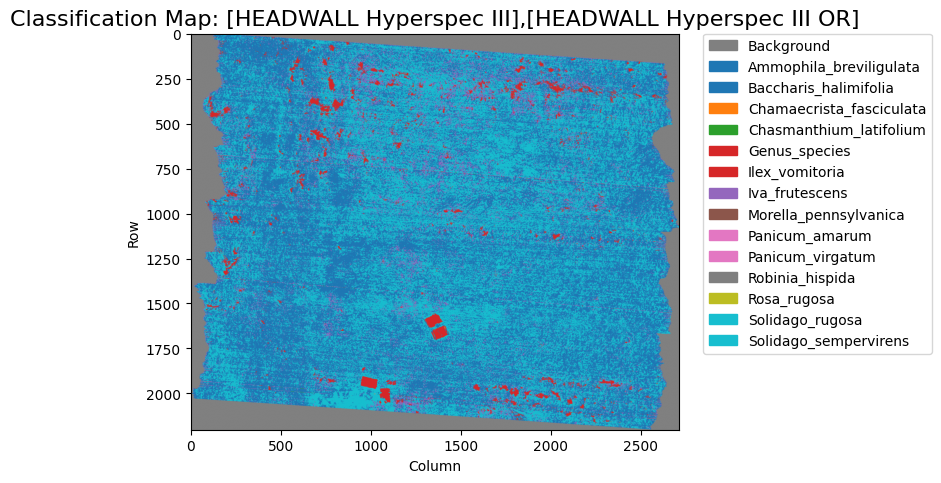

In [5]:
import spectral
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

def display_envi_classification(hdr_path):
    """
    Opens and displays an ENVI classification image with a proper legend.

    Args:
        hdr_path (str): The full file path to the .hdr file of the classification image.
    """
    try:
        # --- 1. Open the ENVI Classification File ---
        # The spectral.open_image function reads the header and prepares to load data.
        img = spectral.open_image(hdr_path)
        print(f"Successfully opened: {hdr_path}")
        print(f"Image dimensions (Rows, Cols, Bands): {img.shape}")

        # --- 2. Load the Classification Data ---
        # .load() reads the entire image into a NumPy array.
        # For single-band classification images, the shape will be (rows, cols, 1).
        # We use [:, :, 0] or np.squeeze() to get a 2D array for plotting.
        class_map = img.load()
        if class_map.ndim == 3 and class_map.shape[2] == 1:
            class_map = class_map[:, :, 0]

    except Exception as e:
        print(f"Error: Could not open or read the file '{hdr_path}'.")
        print(f"Details: {e}")
        return

    # --- 3. Extract Metadata for the Legend ---
    # The class names are stored in the header's metadata.
    # The background value (-1 in our case) is often not in the class names list.
    class_names = img.metadata.get('class names', [])
    if not class_names:
        print("Warning: Could not find 'class names' in the header file.")
        # Create generic names if none are found
        num_classes = int(class_map.max()) + 1
        class_names = [f'Class {i}' for i in range(num_classes)]

    # --- 4. Prepare for Plotting ---
    
    # Get the unique integer values in our map (e.g., -1, 0, 1, 2...).
    # The background is -1, and classes start at 0.
    class_values = np.unique(class_map)
    
    # Use a default colormap (like 'jet' or 'viridis') and add a specific color for the background.
    # Matplotlib's 'tab20' is good for categorical data.
    cmap_colors = plt.cm.get_cmap('tab10', len(class_names))
    
    # Create a new list of colors. Start with gray for the background (-1).
    colors = ['#808080'] + [cmap_colors(i) for i in range(len(class_names))]
    
    # Create a colormap object from our list of colors.
    custom_cmap = ListedColormap(colors)
    
    # Create a normalization object to map each class value to the correct color.
    # The boundaries ensure that each integer value gets a solid color block.
    bounds = np.arange(len(colors) + 1) - 1.5 # e.g., [-1.5, -0.5, 0.5, 1.5, ...]
    norm = plt.matplotlib.colors.BoundaryNorm(bounds, len(colors))

    # --- 5. Create the Plot and Legend ---
    fig, ax = plt.subplots(figsize=(10, 10))

    # Display the classification map using our custom colormap and normalization.
    im_plot = ax.imshow(class_map, cmap=custom_cmap, norm=norm)

    ax.set_title(f"Classification Map: {img.metadata.get('description', 'Untitled')}", fontsize=16)
    ax.set_xlabel("Column")
    ax.set_ylabel("Row")

    # Create legend handles manually.
    legend_labels = ['Background'] + class_names
    patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in range(len(legend_labels))]

    # Add the legend to the plot.
    ax.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Improve layout and display the plot.
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make room for legend
    plt.show()


# --- USAGE EXAMPLE ---
# Replace this with the actual path to one of your output classification files.
# For example, if you saved a 'plant' classification for 'my_image.hdr'.
file_to_display = 'output/temp5/raw_55691_or_ref_plant_classification.hdr' 

# Call the function to display the image
display_envi_classification(file_to_display)